# Data analysis books for UBike services
We require to install **pandas**, **metplotlib** and **seaborn** in the virtual environment. 


In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display

#pd.set_option('display.max_rows',30)
#pd.set_option('large_repr', 'info')

# read data here
bikecsv = pd.read_csv('data/youbike_240518.csv') 

bikecsv

,_id,station_no,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time
0,66477f00ffd73e577b8e8ee9,500101001,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00
1,66477f00ffd73e577b8e8eea,500101002,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00
2,66477f00ffd73e577b8e8eeb,500101003,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00
3,66477f00ffd73e577b8e8eec,500101004,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00
4,66477f00ffd73e577b8e8eed,500101005,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
407025,6648cf54ffd73e577b94c5f9,500119087,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00
407026,6648cf54ffd73e577b94c5fa,500119088,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00
407027,6648cf54ffd73e577b94c5fb,500119089,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00
407028,6648cf54ffd73e577b94c5fc,500119090,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00


## Before analyses, it requires us to know columns in csv data

**Here is the table show meaning or types of data.**

| Column Name | Type (Numerical/Category) | nullable | description |
| --- | --- | --- | --- |
| _id | Categorical | non-null | uuid generated by mongoDB also serial id |  
| station_no | Categorical | non-null | Serial Number |  
| station_name | Categorical | non-null | Station name |  
| district | Categorical | non-null | stations in which districts |  
| total | Numerical |  non-null | total = used + empty| 
| rentAvailable | Numerical |  non-null | available rental seats in stations | 
| returnAvaiable | Numerical |  non-null | avaiable return seats in stations | 
| updated_time | Date String | non-null | date time string in TZ GMT+8 |
|info_time | Date String | non-null | date time string in TZ GMT+8 |

Also, `info_time` can be categorize as workday or weekend to analyse 

## After Identify meanings of data columns, Here is a check list to process the dataframe

In [41]:
import ipywidgets as widgets

cb1 = widgets.Checkbox(description="define the outliers according to description of columns")
cb2 = widgets.Checkbox(description="define the error data in csv and remove them")
cb3 = widgets.Checkbox(description="process date string with pandas")
cb4 = widgets.Checkbox(description="Drop Some serial ID columns")

pb = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def on_button_clicked(b):
    print("clicked on:",b)
    print("cb1:", cb1.value)
    print("cb2:", cb2.value)
    print("cb3:", cb3.value)
    print("cb4:", cb4.value)

pb.on_click(on_button_clicked)

ui = widgets.VBox([widgets.VBox([cb1, cb2, cb3, cb4]),pb])

display(ui)

In [42]:
print('In the Step: we are going to drop serial columns')
# drop column here axis=0 indicates data in row, axis=1 indicates data in column
bikecsv = bikecsv.drop(axis=1, columns=['_id', 'station_no'])
bikecsv

In the Step: we are going to drop serial columns


,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time
0,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00
1,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00
2,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00
3,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00
4,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00
...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00
407026,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00
407027,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00
407028,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00


In [43]:
print('In the Step: we are going to drop error data')

filtered = bikecsv.loc[bikecsv['total'] != bikecsv['rentAvailable']+bikecsv['returnAvaiable'],:]

print('Error data Percentage: '+str(round(len(filtered)/len(bikecsv),4) * 100)+'%')

bikecsv = bikecsv.loc[bikecsv['total'] == bikecsv['rentAvailable']+bikecsv['returnAvaiable'],:]


In the Step: we are going to drop error data
Error data Percentage: 12.22%


In [44]:
print('Let\'s show some insight of date')

## convert datetime strings to datetime formats
bikecsv['info_time'] = pd.to_datetime(bikecsv['info_time'],format='%Y-%m-%d %H:%M:%S')
bikecsv['updated_time'] = pd.to_datetime(bikecsv['updated_time'],format='%Y-%m-%d %H:%M:%S')
bikecsv.loc[:,['info_time','updated_time']]

Let's show some insight of date


/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/292183115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikecsv['info_time'] = pd.to_datetime(bikecsv['info_time'],format='%Y-%m-%d %H:%M:%S')
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/292183115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikecsv['updated_time'] = pd.to_datetime(bikecsv['updated_time'],format='%Y-%m-%d %H:%M:%S')


,info_time,updated_time
0,2024-05-18 00:00:00,2024-05-17 23:58:23
1,2024-05-18 00:00:00,2024-05-17 23:58:23
2,2024-05-18 00:00:00,2024-05-17 23:58:23
3,2024-05-18 00:00:00,2024-05-17 23:58:23
4,2024-05-18 00:00:00,2024-05-17 23:58:23
...,...,...
407025,2024-05-18 23:55:00,2024-05-18 23:53:24
407026,2024-05-18 23:55:00,2024-05-18 23:53:24
407027,2024-05-18 23:55:00,2024-05-18 23:53:24
407028,2024-05-18 23:55:00,2024-05-18 23:53:24


In [45]:
## calculate time difference between station updated time and current time
timeDiff = (bikecsv['info_time'] - bikecsv['updated_time']) / pd.Timedelta(minutes=1)

bikecsv['TimeDiff'] = timeDiff

bikecsv

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/1692005666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikecsv['TimeDiff'] = timeDiff


,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff
0,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667
1,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667
2,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667
3,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667
4,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667
...,...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000
407026,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000
407027,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000
407028,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000


In [46]:
## judge if current time is workday or not
def isWorkHour (timeSeries):
    work_day = timeSeries.weekday() < 5
    work_hour = timeSeries.hour >= 8 & timeSeries.hour < 19
    return work_day & work_hour

workday = bikecsv['info_time'].apply(isWorkHour)

bikecsv['isWorkDay'] = workday

bikecsv

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/3703296375.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikecsv['isWorkDay'] = workday


,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,isWorkDay
0,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
1,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
2,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
3,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
4,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False
...,...,...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407026,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407027,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False
407028,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False


In [47]:
## Add ratio between rentAvailable and total
bikecsv['ratio'] = bikecsv['rentAvailable'] / bikecsv['total'] * 100

bikecsv

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/2120478456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikecsv['ratio'] = bikecsv['rentAvailable'] / bikecsv['total'] * 100


,station_name,station_name_en,district,district_en,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,isWorkDay,ratio
0,YouBike2.0_捷運科技大樓站,YouBike2.0_MRT Technology Bldg. Sta.,大安區,Daan Dist.,28,2,26,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,7.142857
1,YouBike2.0_復興南路二段273號前,YouBike2.0_No.273， Sec. 2， Fuxing S. Rd.,大安區,Daan Dist.,21,4,17,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,19.047619
2,YouBike2.0_國北教大實小東側門,YouBike2.0_NTUE Experiment Elementary School (...,大安區,Daan Dist.,16,10,6,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,62.500000
3,YouBike2.0_和平公園東側,YouBike2.0_Heping Park (East),大安區,Daan Dist.,11,3,8,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,27.272727
4,YouBike2.0_辛亥復興路口西北側,YouBike2.0_Xinhai Fuxing Rd. Intersection (Nor...,大安區,Daan Dist.,16,4,12,2024-05-17 23:58:23,2024-05-18 00:00:00,1.616667,False,25.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
407025,YouBike2.0_臺大總圖書館西南側,YouBike2.0_NTU Main Library(Southwest),臺大公館校區,NTU Dist,30,0,30,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407026,YouBike2.0_臺大黑森林西側,YouBike2.0_NTU Black Forest(West),臺大公館校區,NTU Dist,20,0,20,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407027,YouBike2.0_臺大獸醫館南側,YouBike2.0_NTU Dept. of Veterinary Medicine(So...,臺大公館校區,NTU Dist,24,0,24,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000
407028,YouBike2.0_臺大新體育館東南側,YouBike2.0_NTU Sports Center(Southeast),臺大公館校區,NTU Dist,40,0,40,2024-05-18 23:53:24,2024-05-18 23:55:00,1.600000,False,0.000000


In [48]:
groupByHourAndDistrict = bikecsv.groupby([bikecsv['info_time'].dt.hour, 'district_en'])

groupByHourAndDistrict['ratio'].agg([np.mean, np.std,np.min, np.max])

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/812420561.py:3: FutureWarning: The provided callable <function mean at 0x7fabf0efac20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  groupByHourAndDistrict['ratio'].agg([np.mean, np.std,np.min, np.max])
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/812420561.py:3: FutureWarning: The provided callable <function std at 0x7fabf0efad40> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  groupByHourAndDistrict['ratio'].agg([np.mean, np.std,np.min, np.max])
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/812420561.py:3: FutureWarning: The provided callable <function min at 0x7fabf0efa440> is currently using SeriesGroupBy.min. In a future version of

mean        std  min         max
info_time district_en                                           
0         Beitou Dist      46.190378  31.482052  0.0  100.000000
          Daan Dist.       34.969987  32.094381  0.0  100.000000
          Datong Dist      61.802105  33.774839  0.0  100.000000
          NTU Dist          6.248771  13.314501  0.0   64.285714
          Nangang Dist     46.034831  33.309856  0.0  100.000000
...                              ...        ...  ...         ...
23        Wanhua Dist      52.898007  28.216650  0.0  100.000000
          Wenshan Dist     42.133486  30.073866  0.0  100.000000
          Xinyi Dist       43.662192  33.842326  0.0  100.000000
          Zhongshan Dist   46.223150  34.838673  0.0  100.000000
          Zhongzheng Dist  29.533575  32.169554  0.0  100.000000

[312 rows x 4 columns]

In [49]:
groupByHourAndDistrict['ratio'].mean().unstack()

district_en,Beitou Dist,Daan Dist.,Datong Dist,NTU Dist,Nangang Dist,Neihu Dist,Shilin Dist,Songshan Dist,Wanhua Dist,Wenshan Dist,Xinyi Dist,Zhongshan Dist,Zhongzheng Dist
info_time,,,,,,,,,,,,,
0,46.190378,34.969987,61.802105,6.248771,46.034831,28.772927,44.120505,43.846966,52.784458,38.345951,33.815349,40.978299,27.578159
1,45.887216,35.333590,61.240072,8.774955,47.167199,31.134940,46.334491,46.303794,52.793693,40.294132,37.162900,41.660446,26.823576
2,45.505884,35.060590,63.023992,10.712549,47.582763,33.037335,48.464290,45.673272,53.210856,42.724860,35.937989,42.123907,26.713873
3,45.259907,37.092576,64.374979,11.072052,48.366874,34.399807,48.612367,47.189904,52.915715,44.083533,34.197522,42.605054,27.935018
4,44.589662,39.640083,64.321635,12.044250,48.925991,36.803628,48.474491,49.279023,54.219200,44.934231,36.108113,42.915142,29.057346
5,43.987320,40.223402,64.588099,14.623145,49.182320,37.959025,49.678993,49.669390,52.761435,44.066581,35.922787,43.315110,30.221993
6,41.322132,38.741961,63.199015,16.081046,48.557153,37.174278,49.574526,48.556629,49.035780,42.248269,35.017081,41.207938,32.215904
7,38.557429,37.118194,60.964234,17.025403,46.935373,35.502954,46.423173,47.347131,45.020645,38.191828,34.697301,39.561826,33.966003
8,37.890015,32.811344,55.045648,26.630114,46.947902,34.938073,45.308132,47.105048,43.251838,35.596946,34.653112,39.253544,35.874061


/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_59496/3233287599.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped.columns))


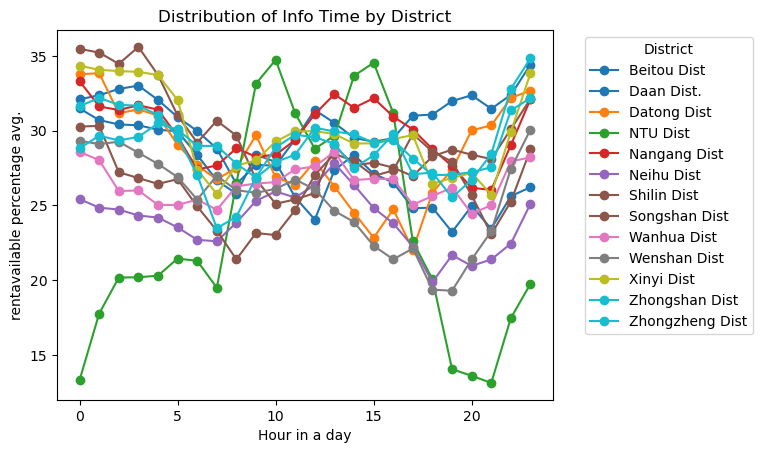

<Figure size 6400x3200 with 0 Axes>

In [58]:

# 按照 'district_en' 和 'info_time' 聚合
grouped = groupByHourAndDistrict['ratio'].std().unstack()

colors = plt.cm.get_cmap('tab10', len(grouped.columns))

for i,area in enumerate(grouped.columns):
    plt.plot(grouped.index, grouped[area], marker='o', label=area, color=colors(i))

plt.title('Distribution of Info Time by District')
plt.xlabel('Hour in a day')
plt.ylabel('rentavailable percentage avg.')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.tight_layout()
plt.figure(figsize=(64, 32))
plt.show()

In [59]:
bikecsv.describe()

,total,rentAvailable,returnAvaiable,updated_time,info_time,TimeDiff,ratio
count,357291.000000,357291.000000,357291.000000,357291,357291,357291.000000,357291.000000
mean,24.580384,8.788489,15.791895,2024-05-18 12:06:50.180108288,2024-05-18 12:08:26.570224896,1.606502,37.189554
min,5.000000,0.000000,0.000000,2024-05-17 23:58:23,2024-05-18 00:00:00,1.516667,0.000000
25%,15.000000,2.000000,8.000000,2024-05-18 06:13:23,2024-05-18 06:15:01,1.583333,11.764706
50%,20.000000,7.000000,13.000000,2024-05-18 12:18:25,2024-05-18 12:20:00,1.600000,32.558140
75%,30.000000,12.000000,21.000000,2024-05-18 18:03:27,2024-05-18 18:05:01,1.616667,58.823529
max,99.000000,98.000000,99.000000,2024-05-18 23:53:24,2024-05-18 23:55:00,3.616667,100.000000
std,13.435514,8.923909,12.323979,NaN,NaN,0.118642,29.121448
